# Проект: классификация

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df.balance.value_counts()

0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance']=df['balance'].str.replace('$', '')
df['balance']=df['balance'].str.replace(' ', '')
df['balance']=df['balance'].str.replace(',00', '')
df.balance=df.balance.astype('float')
round(df.balance.mean(),3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df.balance = df.balance.fillna(df.balance.median())

### Задание 5

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job']=df['job'].str.replace('unknown', df.job.mode()[0])
df['education']=df['education'].str.replace('unknown', df.education.mode()[0])
round((df[(df['job']==df.job.mode()[0]) & (df['education']==df.education.mode()[0])].balance.mean()),3)

1598.883

### Задание 6

In [10]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    #print(outliers)
    return outliers, cleaned
outliers, cleaned=outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [11]:
cleaned.deposit.value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
import plotly.express as plx
fig1 = plx.histogram(cleaned.deposit,
                     title='Number of clients with/without deposits',
                     width = 500,
                     height = 400
            )
fig1.show()


### Задания 2 и 3

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(cleaned.month.value_counts())
display(cleaned.job.value_counts())

may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: month, dtype: int64

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

### Задания 4 и 5

In [14]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
fig2 = plx.histogram(cleaned.age,
                     title='clients age distribution',
                     width = 500,
                     height = 400
            )
fig2.show()
fig3 = plx.histogram(cleaned.duration,
                     title='Duration of the last call with a client',
                     width = 500,
                     height = 400
            )
fig3.show()
display(cleaned.age.max())
display(cleaned.duration.min())

95

2

### Задание 6

In [15]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
cleaned['poutcome'].groupby(cleaned.deposit).value_counts()

deposit  poutcome
no       unknown     4562
         failure      562
         other        216
         success       84
yes      unknown     3008
         success      861
         failure      547
         other        265
Name: poutcome, dtype: int64

### Задание 7

In [16]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
cleaned['deposit'].groupby(cleaned.month).value_counts(normalize=True)
fig3 = plx.histogram(cleaned.deposit, color = cleaned.month)
fig3.show()

### Задание 8

In [17]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_group'] = pd.cut(cleaned['age'], bins=[0, 30, 40, 50, 60, 100])
fig4=plx.histogram(cleaned.deposit, color = cleaned.age_group, title='Deposit openings by client age')
fig4.show()

### Задания 9 и 10

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig5=plx.histogram(cleaned.deposit, color = cleaned.marital, 
                   title='Deposit openings by marital status', 
                   width=600, 
                   height = 500)
fig5.show()

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig6=plx.histogram(cleaned.deposit, color = cleaned.education, 
                   title='Deposit openings by education type', 
                   width=600, 
                   height = 500)
fig6.show()

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig6=plx.histogram(cleaned.deposit, color = cleaned.job, 
                   title='Deposit openings by job sphere', 
                   width=600, 
                   height = 500)
fig6.show()

### Задание 11

In [21]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
cleaned_opened_deposit=cleaned[cleaned.deposit=='yes']
cleaned_refused_deposit=cleaned[cleaned.deposit=='no']


In [22]:
cleaned_pivot=pd.pivot_table(
    #строим заданную пивот таблицу
    cleaned_opened_deposit,
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)
fig7 = plx.imshow(
    cleaned_pivot,
    labels={'color':'Number of opened a deposit by category'}, #подпись легенды
    color_continuous_scale='Reds', #палитра цветов
    width=800, #ширина
    height=500, #высота
    title = 'Opened deposits by education and marital status'
)
fig7.show()

In [23]:
cleaned_pivot=pd.pivot_table(
    #строим заданную пивот таблицу
    cleaned_refused_deposit,
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)
fig7 = plx.imshow(
    cleaned_pivot,
    labels={'color':'Number of refused to open a deposit by category'}, #подпись легенды
    color_continuous_scale='Reds', #палитра цветов
    width=800, #ширина
    height=500, #высота
    title = 'Refused to open a deposit by education and marital status'
)
fig7.show()

## Часть 3: преобразование данных

### Задание 1

In [24]:
# преобразуйте уровни образования
labelencoder = LabelEncoder()
cleaned.education = labelencoder.fit_transform(cleaned.education)

In [25]:
cleaned.education.sum()

11995

### Задания 2 и 3

In [26]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned.age_group = labelencoder.fit_transform(cleaned.age_group)
cleaned = pd.get_dummies (cleaned, columns=['deposit'], drop_first= True )
cleaned['deposit']=cleaned.deposit_yes
cleaned.drop('deposit_yes', axis=1, inplace=True)
round(cleaned.deposit.std(),3)

0.499

### Задание 4

In [27]:
# создайте дамми-переменные
dummies = ['default','housing','loan']
cleaned = pd.get_dummies(cleaned , columns = dummies, drop_first= True)


In [28]:
round(((cleaned.default_yes+cleaned.housing_yes+cleaned.loan_yes).mean()),3)

0.635

In [29]:
dummies2 = ['job','marital', 'contact', 'month', 'poutcome']
cleaned = pd.get_dummies(cleaned , columns = dummies2)

In [30]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   balance            10105 non-null  float64
 3   day                10105 non-null  int64  
 4   duration           10105 non-null  int64  
 5   campaign           10105 non-null  int64  
 6   pdays              10105 non-null  int64  
 7   previous           10105 non-null  int64  
 8   age_group          10105 non-null  int32  
 9   deposit            10105 non-null  uint8  
 10  default_yes        10105 non-null  uint8  
 11  housing_yes        10105 non-null  uint8  
 12  loan_yes           10105 non-null  uint8  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

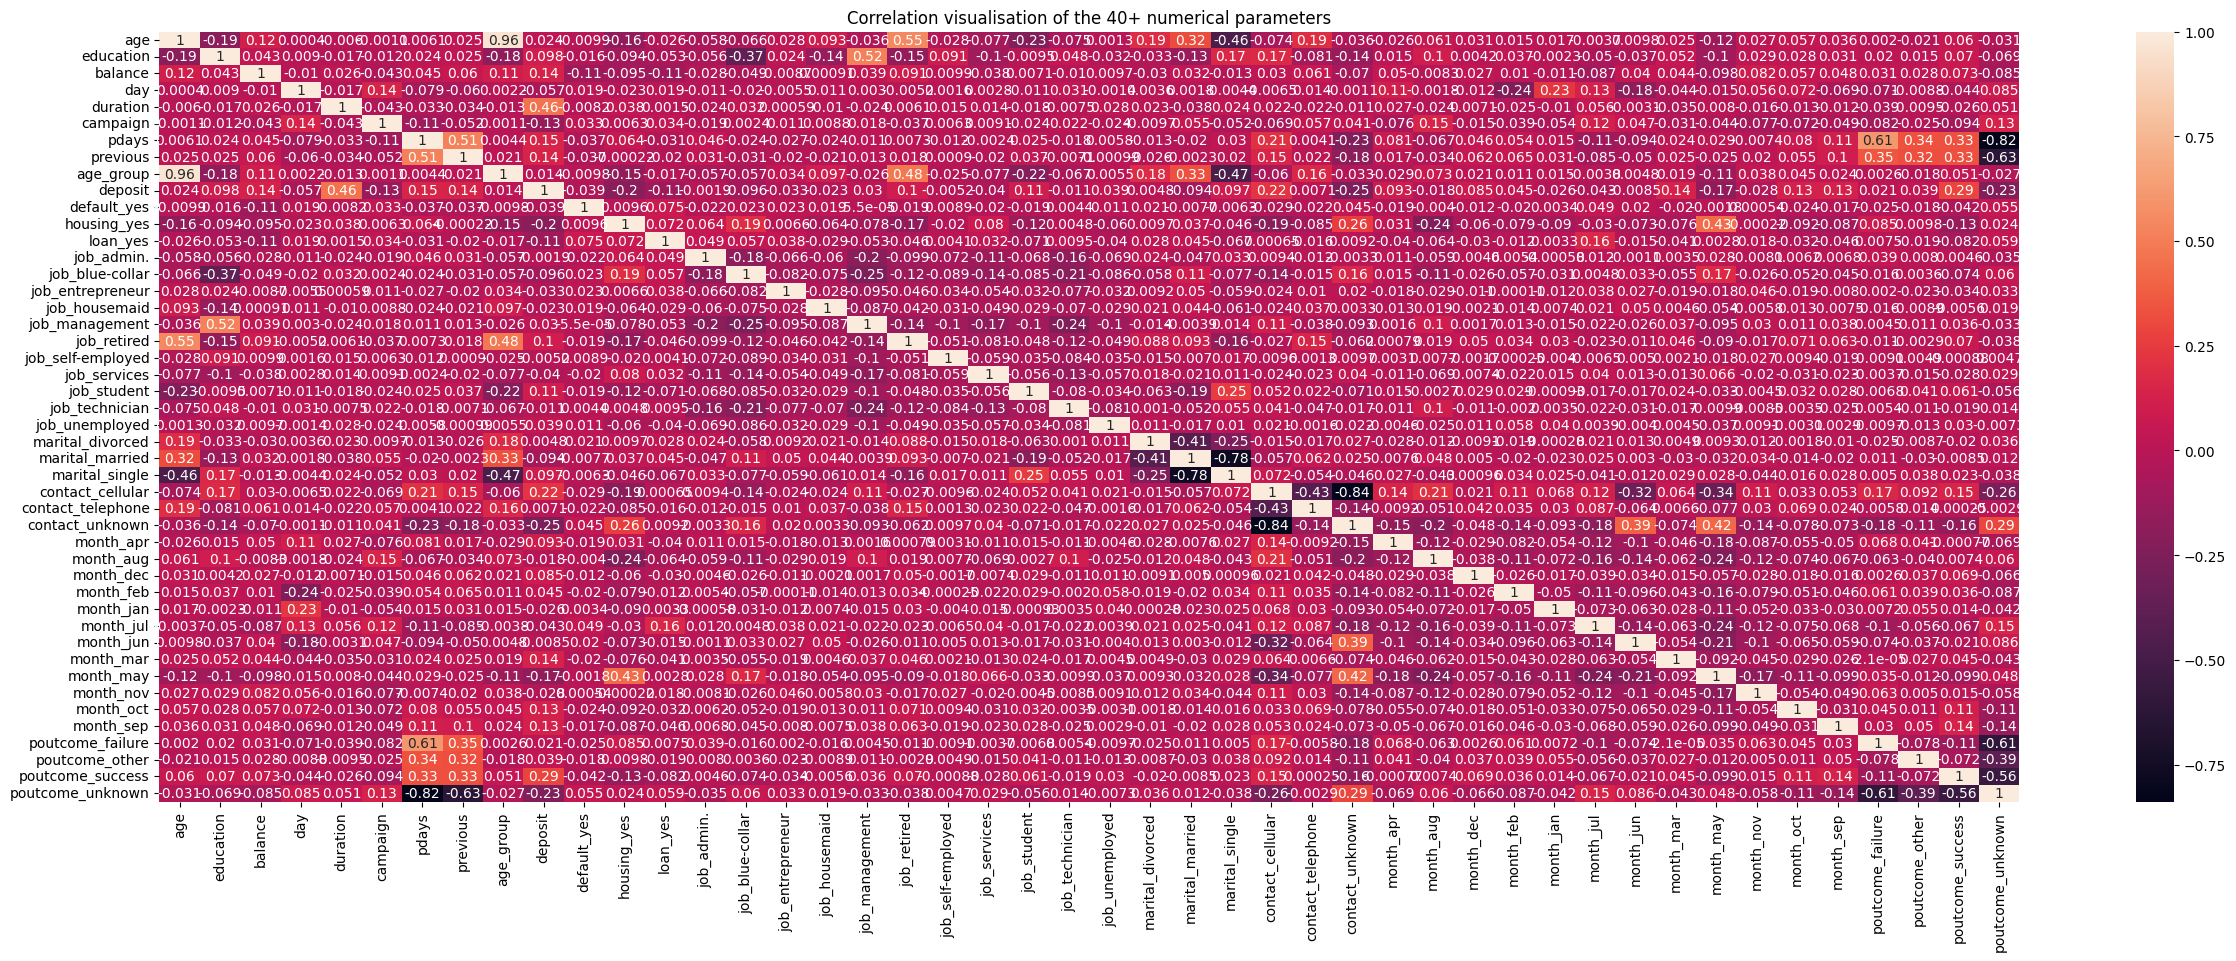

In [31]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30,10))
ax = sns.heatmap(cleaned.corr(), annot=True)
ax.set_title("Correlation visualisation of the 40+ numerical parameters")
plt.show()

In [32]:
for i in cleaned.columns:
    fig = plx.bar(cleaned.corr(), y=i, width = 500)
    fig.show()

### Задания 7 и 8

In [33]:
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [34]:
# рассчитайте необходимые показатели
X_test.shape
y_test.mean()

0.46326836581709147

### Задание 9

In [35]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()


array(['balance', 'duration', 'campaign', 'pdays', 'previous',
       'housing_yes', 'loan_yes', 'contact_cellular', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

In [36]:
cleaned

,age,education,balance,day,duration,campaign,pdays,previous,age_group,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,2343.0,5,1042,1,-1,0,3,1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,45.0,5,1467,1,-1,0,3,1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,1270.0,5,1389,1,-1,0,2,1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,2476.0,5,579,1,-1,0,3,1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,184.0,5,673,2,-1,0,3,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,1.0,20,257,1,-1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,733.0,16,83,4,-1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,29.0,19,156,2,-1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0.0,8,9,2,172,5,2,0,...,0,0,1,0,0,0,1,0,0,0


In [37]:
X_new = cleaned[['balance', 'duration', 'campaign', 'pdays', 'previous',
       'housing_yes', 'loan_yes', 'contact_cellular', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success', 'poutcome_unknown']]

In [51]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           10105 non-null  float64
 1   duration          10105 non-null  int64  
 2   campaign          10105 non-null  int64  
 3   pdays             10105 non-null  int64  
 4   previous          10105 non-null  int64  
 5   housing_yes       10105 non-null  uint8  
 6   loan_yes          10105 non-null  uint8  
 7   contact_cellular  10105 non-null  uint8  
 8   contact_unknown   10105 non-null  uint8  
 9   month_mar         10105 non-null  uint8  
 10  month_may         10105 non-null  uint8  
 11  month_oct         10105 non-null  uint8  
 12  month_sep         10105 non-null  uint8  
 13  poutcome_success  10105 non-null  uint8  
 14  poutcome_unknown  10105 non-null  uint8  
dtypes: float64(1), int64(4), uint8(10)
memory usage: 572.4 KB


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, random_state = 42, test_size = 0.33)

In [52]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [40]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# нормализуйте данные с помощью minmaxsxaler
scaler1 = preprocessing.MinMaxScaler()
scaler1.fit(X_train1)
X_train_scaled1 = scaler1.transform(X_train1)
X_test_scaled1 = scaler1.transform(X_test1)

In [41]:
round(X_test_scaled[:,0].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [55]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled1, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [56]:
#Делаем предсказание для тренировочной выборки
#y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
#print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred1 = log_reg.predict(X_test_scaled1)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test1, y_test_pred1))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.76      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [60]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X_train_scaled1, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [62]:
#Делаем предсказание для тренировочной выборки
y_train_pred2 = dt_clf_2d.predict(X_train_scaled1)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train1, y_train_pred2))
#Делаем предсказание для тестовой выборки
y_test_pred2 = dt_clf_2d.predict(X_test_scaled1)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test1, y_test_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1790
           1       0.78      0.75      0.76      1545

    accuracy                           0.79      3335
   macro avg       0.78      0.78      0.78      3335
weighted avg       0.79      0.79      0.78      3335



In [64]:
for i in range (1,10):
    dt_clf_2d = tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности 
        random_state=42, #генератор случайных чисел
        max_depth = i
    )
    #Обучаем дерево решений по алгоритму CART
    dt_clf_2d.fit(X_train_scaled1, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_pred2 = dt_clf_2d.predict(X_train_scaled1)
    #Вывод отчет о метриках классификации
    print(metrics.classification_report(y_train1, y_train_pred2))
    #Делаем предсказание для тестовой выборки
    y_test_pred2 = dt_clf_2d.predict(X_test_scaled1)
    #Вывод отчет о метриках классификации
    print(metrics.classification_report(y_test1, y_test_pred2))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69      3634
           1       0.65      0.84      0.73      3136

    accuracy                           0.71      6770
   macro avg       0.73      0.72      0.71      6770
weighted avg       0.73      0.71      0.71      6770

              precision    recall  f1-score   support

           0       0.79      0.62      0.69      1790
           1       0.65      0.81      0.72      1545

    accuracy                           0.71      3335
   macro avg       0.72      0.71      0.71      3335
weighted avg       0.72      0.71      0.70      3335

              precision    recall  f1-score   support

           0       0.69      0.90      0.78      3634
           1       0.82      0.54      0.65      3136

    accuracy                           0.73      6770
   macro avg       0.75      0.72      0.71      6770
weighted avg       0.75      0.73      0.72      6770

              preci

### Задание 5

In [88]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности 
        random_state=42 #генератор случайных чисел
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred3 = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred3)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 183 ms
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [94]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf=5,
    max_depth=10, 
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_test5 = rf_clf_2d.predict(X_test_scaled)
#Выводим отчет о метриках
print(metrics.classification_report(y_test, y_pred_test5))
print('Train: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test5)))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Train: 0.83


### Задания 2 и 3

In [95]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел
    min_samples_leaf=5,
)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print('Train: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

Train: 0.81


### Задание 4

In [104]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingRegressor
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

#Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
#Обучаем модель
reg.fit(X_train_scaled1, y_train1)
y_pred = reg.predict(X_test_scaled1)
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Задание 5

In [110]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = GradientBoostingClassifier()
from sklearn.feature_selection import RFE
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_



['duration' 'contact_unknown' 'poutcome_success']
Index(['balance', 'duration', 'campaign', 'pdays', 'previous', 'housing_yes',
       'loan_yes', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 5,  1,  9,  2, 12,  3,  8, 13,  1,  4, 11,  6,  7,  1, 10])

### Задания 6,7,8

In [128]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
print("Версия Optuna: {}".format(optuna.__version__))
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train1, model.predict(X_train_scaled))

  return score
  

Версия Optuna: 2.10.1


In [129]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-01-12 16:39:27,572] A new study created in memory with name: RandomForestClassifier
[I 2023-01-12 16:39:30,048] Trial 0 finished with value: 0.8719550281074329 and parameters: {'n_estimators': 179, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8719550281074329.
[I 2023-01-12 16:39:32,403] Trial 1 finished with value: 0.8719550281074329 and parameters: {'n_estimators': 115, 'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8719550281074329.
[I 2023-01-12 16:39:35,140] Trial 2 finished with value: 0.8719550281074329 and parameters: {'n_estimators': 171, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8719550281074329.
[I 2023-01-12 16:39:39,969] Trial 3 finished with value: 0.8719550281074329 and parameters: {'n_estimators': 195, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8719550281074329.
[I 2023-01-12 16:39:44,463] Trial 4 finished with value: 0.8719550281074329 and parameters: {'n_

CPU times: total: 16.5 s
Wall time: 1min 4s


In [130]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 179, 'max_depth': 15, 'min_samples_leaf': 6}
f1_score на обучающем наборе: 0.87


In [131]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
